# Notebook 02 - Antônio Esteves - Avaliação de Cientista de Dados

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()
color = sns.color_palette()
from time import time

from kmodes.kprototypes import KPrototypes
from tpot import TPOTClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = FutureWarning)


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from collections import Counter
from imblearn.over_sampling import SMOTE

from tqdm import tqdm
import math
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100)

## Funções

In [41]:
def evaluate(results, accuracy=None, f1=None):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    fig, ax = plt.subplots(2, 3, figsize = (14,10))

    bar_width = 0.3
    colors = ['#37535E','#4095B5','#93D0BF']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f1_train', 'pred_time', 'acc_test', 'f1_test']):
            for i in np.arange(3):
                
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    ax[0, 0].set_ylabel("Tempo (segundos)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F1-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F1-score")
    
    ax[0, 0].set_title("Tempo de predição do Modelo - Treino")
    ax[0, 1].set_title("Precisão no subconjunto de treino")
    ax[0, 2].set_title("F1-score no subconjunto de treino")
    ax[1, 0].set_title("Tempo de predição do Modelo - Teste")
    ax[1, 1].set_title("Precisão no conjunto de teste")
    ax[1, 2].set_title("F1-score no conjunto de teste")
    
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'r', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'r', linestyle = 'dashed')
    
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    plt.suptitle("Comparativo de métricas dos modelos avaliados", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

## Explorando os Dados

In [4]:
data = pd.read_csv(r'../data/campaigns.csv').drop(['Unnamed: 0'], axis=1)
data.shape

(40690, 17)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40690 entries, 0 to 40689
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40690 non-null  int64 
 1   job        40690 non-null  object
 2   marital    40690 non-null  object
 3   education  40690 non-null  object
 4   default    40690 non-null  object
 5   balance    40690 non-null  int64 
 6   housing    40690 non-null  object
 7   loan       40690 non-null  object
 8   contact    40690 non-null  object
 9   day        40690 non-null  int64 
 10  month      40690 non-null  object
 11  duration   40690 non-null  int64 
 12  campaign   40690 non-null  int64 
 13  pdays      40690 non-null  int64 
 14  previous   40690 non-null  int64 
 15  poutcome   40690 non-null  object
 16  y          40690 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.3+ MB


## Preparação dos Dados

Antes que os dados possam ser usados como entrada para algoritmos de aprendizado de máquina, eles geralmente devem ser limpos, formatados e reestruturados - isso geralmente é conhecido como pré-processamento. Felizmente, para este conjunto de dados, não há entradas inválidas ou ausentes com as quais devemos lidar, no entanto, existem algumas qualidades sobre determinados recursos que devem ser ajustados. Esse pré-processamento pode ajudar tremendamente com o resultado e o poder preditivo de quase todos os algoritmos de aprendizado.

In [6]:
df = data.copy()

In [7]:
binary = {'no': 'F', 'yes': 'T'}

df['default'] = df['default'].map(binary)
df['housing'] = df['housing'].map(binary)
df['loan']    = df['loan'].map(binary)
df['y']       = df['y'].map(binary)

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,F,2143,T,F,unknown,5,may,261,1,-1,0,unknown,F
1,44,technician,single,secondary,F,29,T,F,unknown,5,may,151,1,-1,0,unknown,F
2,33,entrepreneur,married,secondary,F,2,T,T,unknown,5,may,76,1,-1,0,unknown,F
3,47,blue-collar,married,unknown,F,1506,T,F,unknown,5,may,92,1,-1,0,unknown,F
4,33,unknown,single,unknown,F,1,F,F,unknown,5,may,198,1,-1,0,unknown,F


# Agrupamento de Clientes

Para segmentar os dados utilizaremos um algoritmo de clusterização chamado **K-prototypes**. O **K-Prototypes** é um irmão menos conhecido, mas oferece uma vantagem de trabalhar com tipos de dados mistos. Ele mede a distância entre os recursos numéricos usando a distância euclidiana (como médias K), mas também mede a distância entre os recursos categóricos usando o número de categorias correspondentes. Foi publicado pela primeira vez por [Huang (1998)](https://link.springer.com/content/pdf/10.1023/A:1009769707641.pdf) e foi implementado em python usando [este pacote](https://github.com/nicodv/kmodes).

In [63]:
X = df.values

In [77]:
costs = []
n_clusters = []
distorsions = []

for k in tqdm(range(1, 10)):
    try:
        kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
        clusters = kproto.fit_predict(X, categorical=[1,2,3,4,6,7,8,10,15,16])
        
        print(kproto.n_iter_)
        
        costs.append(kproto.cost_)
        n_clusters.append(k)
        distorsions.append(clusters)
    except:
        print(f"Can't cluster with {k} clusters")

  0%|          | 0/9 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 377816936384.50555
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 377816936384.50555
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 377816936384.50555
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 377816936384.50555
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 377816936384.50555
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 377816936384.50555
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 377816936384.50555
Init: 

 11%|█         | 1/9 [02:55<23:24, 175.62s/it]

1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 779, ncost: 184600579294.36456
Run: 1, iteration: 2/100, moves: 478, ncost: 182575013382.25378
Run: 1, iteration: 3/100, moves: 274, ncost: 181735668559.2321
Run: 1, iteration: 4/100, moves: 169, ncost: 181371011719.17612
Run: 1, iteration: 5/100, moves: 81, ncost: 181274790879.30176
Run: 1, iteration: 6/100, moves: 47, ncost: 181239593971.25333
Run: 1, iteration: 7/100, moves: 35, ncost: 181222439774.5733
Run: 1, iteration: 8/100, moves: 15, ncost: 181218260722.68625
Run: 1, iteration: 9/100, moves: 6, ncost: 181217666683.4118
Run: 1, iteration: 10/100, moves: 2, ncost: 181217549215.05054
Run: 1, iteration: 11/100, moves: 1, ncost: 181217531133.32632
Run: 1, iteration: 12/100, moves: 0, ncost: 181217531133.32632
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3273, ncost: 195020387372.2606
Run: 2, iteration:

 22%|██▏       | 2/9 [24:22<59:22, 508.95s/it]

12
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 15127, ncost: 226360685787.83298
Run: 1, iteration: 2/100, moves: 9643, ncost: 187441523696.86166
Run: 1, iteration: 3/100, moves: 19325, ncost: 156195245028.72842
Run: 1, iteration: 4/100, moves: 7553, ncost: 133777779668.88194
Run: 1, iteration: 5/100, moves: 3600, ncost: 119799939253.92592
Run: 1, iteration: 6/100, moves: 1972, ncost: 111433804748.25327
Run: 1, iteration: 7/100, moves: 1103, ncost: 107381304752.72145
Run: 1, iteration: 8/100, moves: 752, ncost: 105208146657.69301
Run: 1, iteration: 9/100, moves: 474, ncost: 103662141044.71994
Run: 1, iteration: 10/100, moves: 373, ncost: 102423361022.1668
Run: 1, iteration: 11/100, moves: 253, ncost: 101944662825.26897
Run: 1, iteration: 12/100, moves: 192, ncost: 101797766919.86859
Run: 1, iteration: 13/100, moves: 133, ncost: 101667408433.76749
Run: 1, iteration: 14/100, moves: 92, ncost: 101626581148.81393
Run: 1, i

 33%|███▎      | 3/9 [51:28<1:24:24, 844.06s/it]

18
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 11363, ncost: 207824696262.1574
Run: 1, iteration: 2/100, moves: 19383, ncost: 169488054456.75363
Run: 1, iteration: 3/100, moves: 10152, ncost: 142144618157.64392
Run: 1, iteration: 4/100, moves: 6320, ncost: 123768285067.88118
Run: 1, iteration: 5/100, moves: 13077, ncost: 107112445783.43303
Run: 1, iteration: 6/100, moves: 11584, ncost: 94483212878.70305
Run: 1, iteration: 7/100, moves: 5649, ncost: 85937895481.27502
Run: 1, iteration: 8/100, moves: 3370, ncost: 78999941767.9616
Run: 1, iteration: 9/100, moves: 2137, ncost: 75500528277.37473
Run: 1, iteration: 10/100, moves: 1628, ncost: 72922391215.90833
Run: 1, iteration: 11/100, moves: 1218, ncost: 70790403585.12457
Run: 1, iteration: 12/100, moves: 847, ncost: 69881894989.98633
Run: 1, iteration: 13/100, moves: 590, ncost: 69389305172.17381
Run: 1, iteration: 14/100, moves: 405, ncost: 69165934680.93317
Run: 1, ite

 44%|████▍     | 4/9 [1:46:24<2:11:38, 1579.66s/it]

35
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 16476, ncost: 166318757448.16086
Run: 1, iteration: 2/100, moves: 13504, ncost: 136182995420.18246
Run: 1, iteration: 3/100, moves: 10352, ncost: 113914051363.79549
Run: 1, iteration: 4/100, moves: 7417, ncost: 97636946568.8877
Run: 1, iteration: 5/100, moves: 5092, ncost: 87089022496.11766
Run: 1, iteration: 6/100, moves: 3567, ncost: 79206591775.6061
Run: 1, iteration: 7/100, moves: 8310, ncost: 72528021417.99677
Run: 1, iteration: 8/100, moves: 10615, ncost: 66972074128.249565
Run: 1, iteration: 9/100, moves: 6083, ncost: 62508652715.89953
Run: 1, iteration: 10/100, moves: 3923, ncost: 59672586004.07768
Run: 1, iteration: 11/100, moves: 2727, ncost: 57841527764.95617
Run: 1, iteration: 12/100, moves: 1928, ncost: 56146725808.41484
Run: 1, iteration: 13/100, moves: 1572, ncost: 53911697855.83654
Run: 1, iteration: 14/100, moves: 1286, ncost: 51375526519.344635
Run: 1, i

 56%|█████▌    | 5/9 [2:47:40<2:27:14, 2208.63s/it]

37
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 10218, ncost: 114431205302.25859
Run: 1, iteration: 2/100, moves: 5069, ncost: 93618325406.75688
Run: 1, iteration: 3/100, moves: 4455, ncost: 80901755132.86136
Run: 1, iteration: 4/100, moves: 4233, ncost: 71292484960.45833
Run: 1, iteration: 5/100, moves: 3717, ncost: 65194116351.332695
Run: 1, iteration: 6/100, moves: 3187, ncost: 60447577313.6342
Run: 1, iteration: 7/100, moves: 2549, ncost: 57699003489.21555
Run: 1, iteration: 8/100, moves: 2092, ncost: 56003217746.203995
Run: 1, iteration: 9/100, moves: 3477, ncost: 53523921091.76977
Run: 1, iteration: 10/100, moves: 7217, ncost: 49192865307.90546
Run: 1, iteration: 11/100, moves: 3439, ncost: 45735949808.20957
Run: 1, iteration: 12/100, moves: 2620, ncost: 42317014847.158394
Run: 1, iteration: 13/100, moves: 2282, ncost: 39439117894.98159
Run: 1, iteration: 14/100, moves: 1854, ncost: 37921702877.99031
Run: 1, iter

 67%|██████▋   | 6/9 [4:04:29<2:26:26, 2928.79s/it]

45
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 6472, ncost: 103897742021.51259
Run: 1, iteration: 2/100, moves: 4480, ncost: 84769311797.51936
Run: 1, iteration: 3/100, moves: 3804, ncost: 73443053243.01411
Run: 1, iteration: 4/100, moves: 3378, ncost: 65401230555.70719
Run: 1, iteration: 5/100, moves: 3062, ncost: 60427576852.52575
Run: 1, iteration: 6/100, moves: 3352, ncost: 57178576597.20272
Run: 1, iteration: 7/100, moves: 10623, ncost: 54367097228.44144
Run: 1, iteration: 8/100, moves: 7605, ncost: 51505550095.219154
Run: 1, iteration: 9/100, moves: 5564, ncost: 47842091121.870316
Run: 1, iteration: 10/100, moves: 4191, ncost: 44593607785.64612
Run: 1, iteration: 11/100, moves: 3170, ncost: 41086215219.51241
Run: 1, iteration: 12/100, moves: 2487, ncost: 38159171427.37798
Run: 1, iteration: 13/100, moves: 2086, ncost: 36486170807.593834
Run: 1, iteration: 14/100, moves: 1798, ncost: 35165867991.93438
Run: 1, ite

 78%|███████▊  | 7/9 [5:18:08<1:52:31, 3375.79s/it]

47
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 6021, ncost: 68795534629.88924
Run: 1, iteration: 2/100, moves: 2995, ncost: 54290346721.90338
Run: 1, iteration: 3/100, moves: 1590, ncost: 48151889851.63855
Run: 1, iteration: 4/100, moves: 1032, ncost: 44150674644.763664
Run: 1, iteration: 5/100, moves: 965, ncost: 39631107467.839066
Run: 1, iteration: 6/100, moves: 1168, ncost: 34849597763.77717
Run: 1, iteration: 7/100, moves: 1305, ncost: 31667211176.040237
Run: 1, iteration: 8/100, moves: 1321, ncost: 29603984197.6096
Run: 1, iteration: 9/100, moves: 1310, ncost: 28479390784.39499
Run: 1, iteration: 10/100, moves: 1257, ncost: 27598826077.548634
Run: 1, iteration: 11/100, moves: 1213, ncost: 26978753424.118988
Run: 1, iteration: 12/100, moves: 989, ncost: 26555943937.679897
Run: 1, iteration: 13/100, moves: 935, ncost: 26107735992.293724
Run: 1, iteration: 14/100, moves: 826, ncost: 25760712590.832024
Run: 1, itera

 89%|████████▉ | 8/9 [6:44:20<1:05:14, 3914.55s/it]

67
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7393, ncost: 107540720819.4614
Run: 1, iteration: 2/100, moves: 6390, ncost: 83663812543.44923
Run: 1, iteration: 3/100, moves: 4345, ncost: 69380064367.38678
Run: 1, iteration: 4/100, moves: 3119, ncost: 58727086612.53514
Run: 1, iteration: 5/100, moves: 2792, ncost: 52361036713.13334
Run: 1, iteration: 6/100, moves: 2817, ncost: 48808618126.009285
Run: 1, iteration: 7/100, moves: 2693, ncost: 45367397828.64767
Run: 1, iteration: 8/100, moves: 2614, ncost: 41678768294.00266
Run: 1, iteration: 9/100, moves: 2539, ncost: 38070252423.21835
Run: 1, iteration: 10/100, moves: 2417, ncost: 34157277790.85529
Run: 1, iteration: 11/100, moves: 2315, ncost: 31766882412.092922
Run: 1, iteration: 12/100, moves: 2284, ncost: 29716639720.294853
Run: 1, iteration: 13/100, moves: 2112, ncost: 28162568130.78847
Run: 1, iteration: 14/100, moves: 1829, ncost: 27383380845.983273
Run: 1, iter

100%|██████████| 9/9 [9:15:33<00:00, 3703.75s/it]  

101


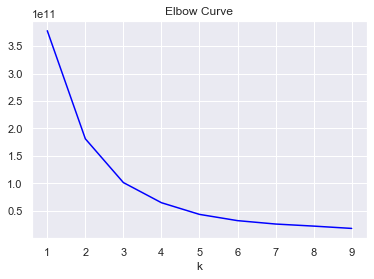

In [78]:
plt.plot(range(1,10), costs, color='blue')
plt.grid(True)
plt.xlabel('k')
plt.title('Elbow Curve')
plt.savefig("../images/elbow_curve.png", bbox_inches='tight')
plt.show()

In [84]:
clusters
# print(kproto.cluster_centroids_)

array([8, 3, 3, ..., 2, 0, 8], dtype=uint16)

## Aplicando Melhor Cluster

In [85]:
n_clusters = 3

In [87]:
kproto = KPrototypes(n_clusters=n_clusters, init='Cao', verbose=2)
clusters = kproto.fit_predict(X, categorical=[1,2,3,4,6,7,8,10,15,16])

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)

# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 13617, ncost: 187815749490.575
Run: 1, iteration: 2/100, moves: 15617, ncost: 156020525217.0776
Run: 1, iteration: 3/100, moves: 6685, ncost: 133797692698.25023
Run: 1, iteration: 4/100, moves: 3439, ncost: 119888001270.44807
Run: 1, iteration: 5/100, moves: 1944, ncost: 111506502840.19885
Run: 1, iteration: 6/100, moves: 1097, ncost: 107448971483.14932
Run: 1, iteration: 7/100, moves: 762, ncost: 105209877732.86626
Run: 1, iteration: 8/100, moves: 475, ncost: 103662984703.66086
Run: 1, iteration: 9/100, moves: 374, ncost: 102423361022.1668
Run: 1, iteration: 10/100, moves: 253, ncost: 101944662825.26897
Run: 1, iteration: 11/100, moves: 192, ncost: 101797766919.86859
Run: 1, iteration: 12/100, moves: 133, ncost: 101667408433.76749
Run: 1, iteration: 13/100, moves: 92, ncost: 101626581148.81393
Run: 1, iteration: 14/100, moves: 36, ncost: 101623408987.59515
Run: 1, iteration

In [88]:
df['cluster'] = clusters

In [6]:
# df.to_csv('../data/data-clustered.csv', sep=';', index=False)
df = pd.read_csv('../data/data-clustered.csv', sep=';',)

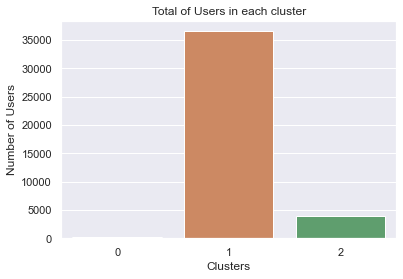

In [7]:
sns.countplot(df['cluster'])
plt.xlabel('Clusters')
plt.ylabel('Number of Users')
plt.title('Total of Users in each cluster')
plt.show()

In [8]:
df = df.drop(['y'], axis=1)
df['duration'] = df['duration'] / 60

Após criados os agrupamentos, vamos visualizar a seguir as nuances de cada agrupamento e como elas segmentam os usuários. Se os clusters forem de alta qualidade, poderemos segmentar clientes com alta precisão. Ao mesmo tempo, os modelos devem usar uma variedade de recursos para garantir que os clusters não sejam muito simplistas.

## Primeiro Agrupamento - Cluster 0

- No primeiro agrupamento usuários entre **30** e **60** anos são mais frequentese. Existem ainda usuários entre **60** e **80**, além de uns pouco usuários acima de **80** anos.


- Os principais clientes desse agrupamento tem como ocupação cargos de **gerencia**, seguidos por **membros da classe trabalhadora** (em geral **trabalhadores de chão de fábrica**) e **aposentados**. Trabalhadores dedicados a área técnica também são destaques nesse agrupamento.


- Clientes desse agrupamento, em sua maioria são **casados**, seguidos pelo **solteiros** e por fim os **divorciados**.


- A **escolaridade** dos clientes nesse agrupamento tem **nível superior**, seguidos pelos usuários com **educação secundária** e por fim àqueles que possuem apenas a **educação primaria**. Uma pequena parcela tem **escolaridade desconhecida** ou não **declarada**.


- É praticamente unânime a presençada de clientes nesse agrupamento que estão em dias com o cumprimento das obrigações legais ou condições de um empréstimo (**default**),


- Clientes dess agrupamento tem em média uma **saldo anual de 2000 euros**. Destaca-se aqui a forte presença daqueles que possuem bem menos que a média de 2000 euros. Além disso, existem ainda alguns clientes que possuem rendas maiores de **6000** a **10000** euros.


- A maior parte dos clientes nesse agrupamento não possuem **hipoteca**. Apesar de ser apresentada uma diferença entre que possui hipoteca ou não, os dois grupos estão equilibrados.


- Grande parte dos clientes nesse agrupamento possui empréstimo pessoal e seu principal meio de contato é por meio de celular.


- Esses clientes foram contactados pela última vez entre os dias **20** e **22** de cada mês, com destaque para os meses de **Novembro**, **Agosto**, **Junho** e **Maio**. Além disso o ultimo contato com esses usuários não foi superior a **5 minutos**. Um segundo grupo, ainda nesse agrupamento, teve a duração do seu ultimo contato entre **5** e **12 minutos**. Uns poucos clientes tiverem a duração desse último contato superior a **25 minutos**.


- A frequência do número de contatos realizados durante esta campanha e para este cliente ficou entre **1** e **5** contatos possíveis. Ainda assim alguns outros contatos foram feitos com maior frequência para outras campanhas e clients.


- O impacto do resultado das campanhas de marketing anteriores para esses clientes é desconhecido ou não relatado. Um total expressivo é apresentado denotando **falha** na campanha de marketing anterior.

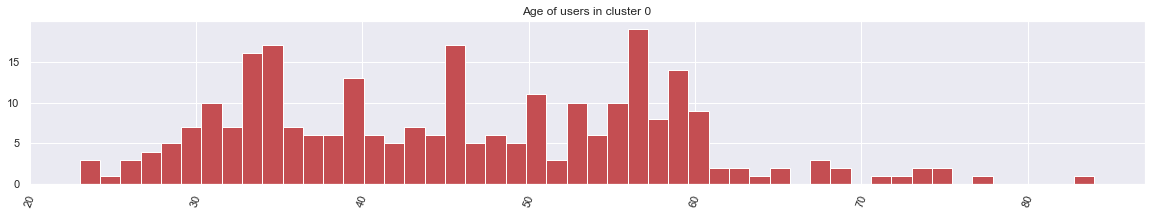

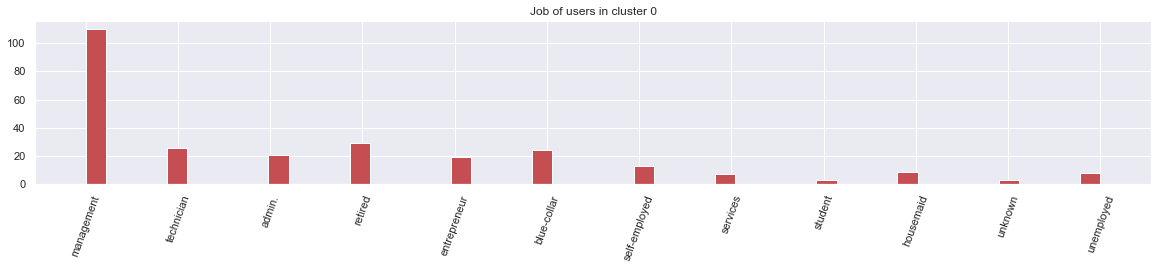

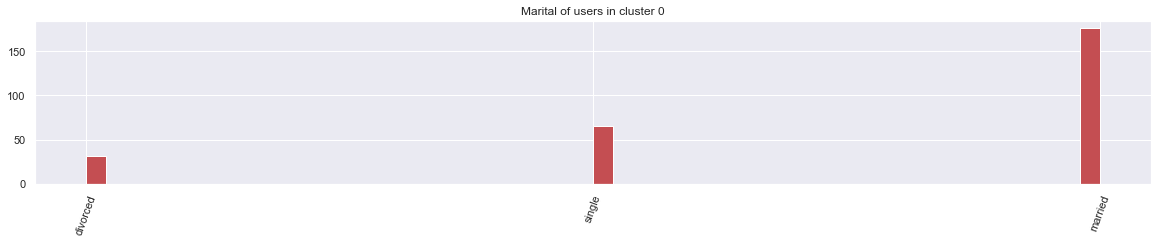

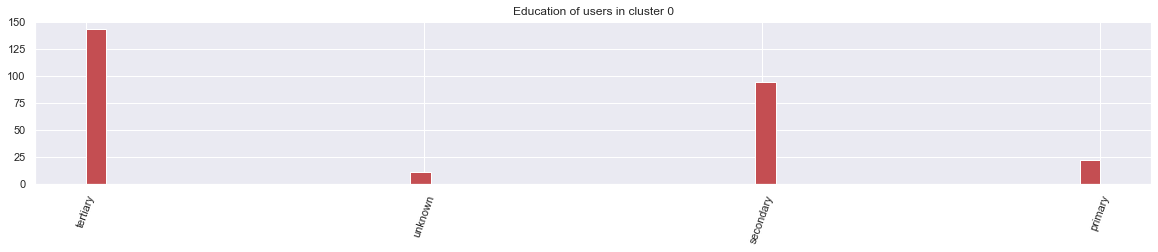

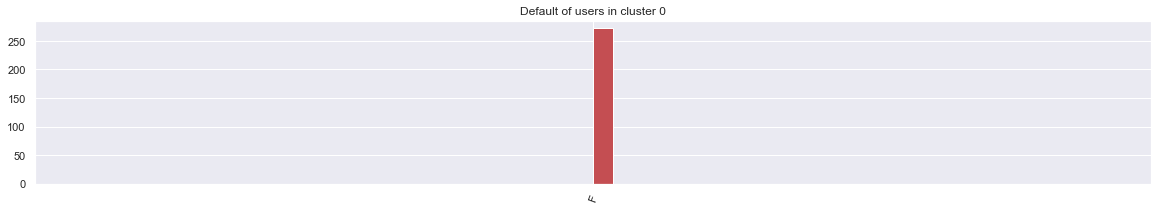

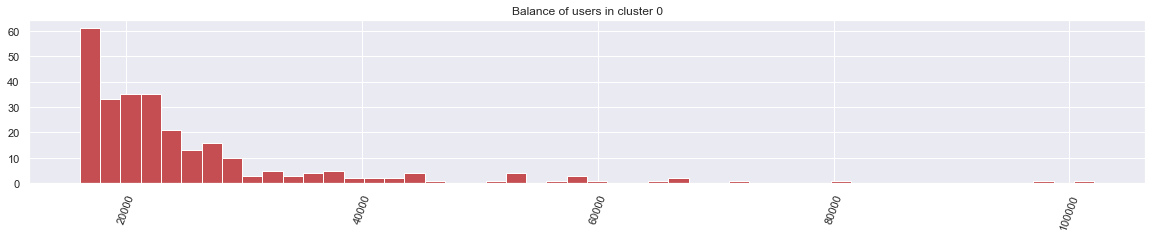

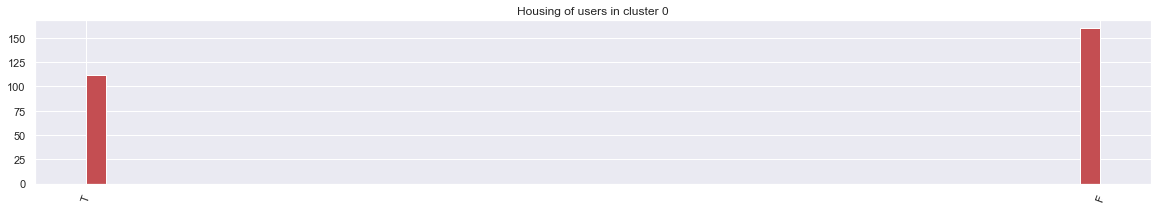

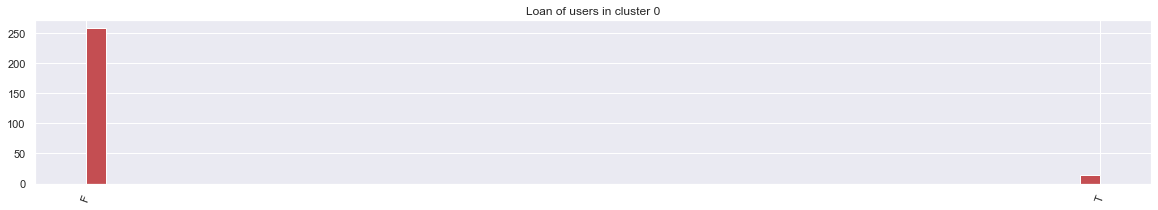

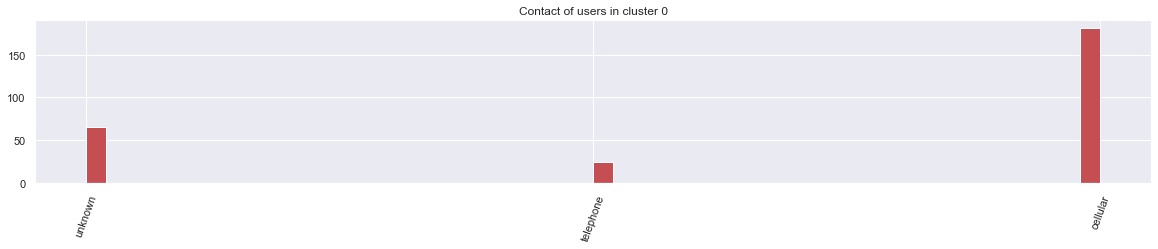

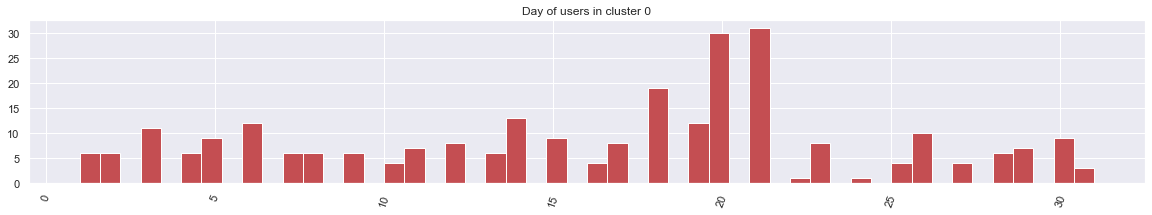

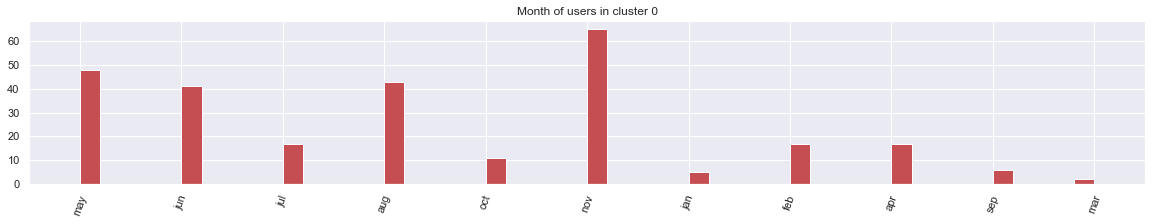

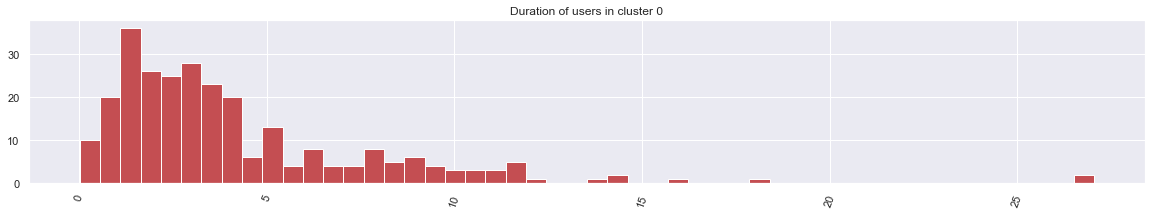

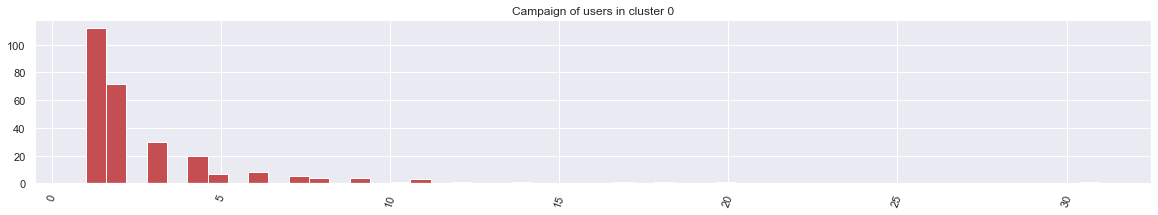

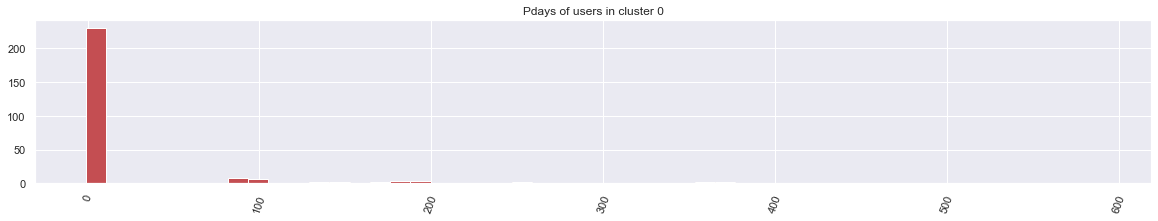

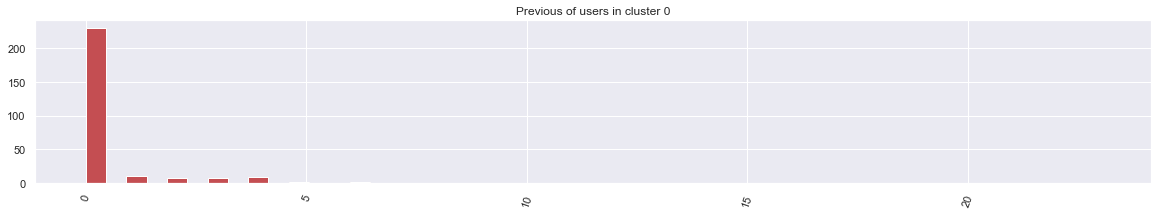

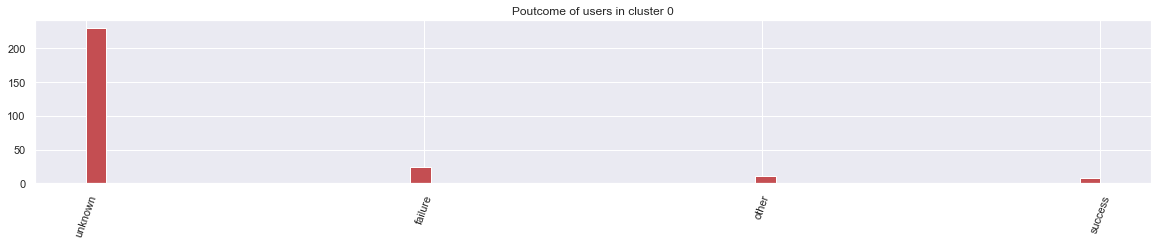

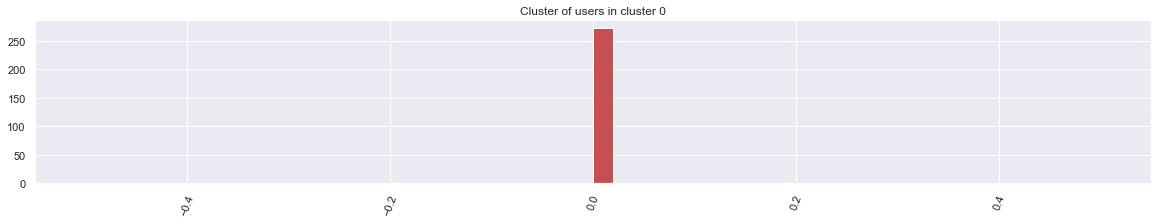

In [9]:
for feature in df.columns:
    plt.subplot(df.loc[:,feature][df['cluster'] == 0].hist(color='r', figsize=(20,3), bins=50))
    plt.title("%s of users in cluster 0" % feature.title().replace('_', ' '))
    plt.xticks(rotation=70)
    plt.show()    

## Segundo Agrupamento - Agrupamento 1

- No segundo agrupamento clientes entre **22** e **60** anos são mais frequentes. Clientes acima de **60** anos são praticamente inexistentes ou se apresentam como uma minória pouco expressiva.


- Novamente principais clientes desse agrupamento tem como ocupação cargos de **gerencia**, seguidos por **membros da classe trabalhadora** (em geral **trabalhadores de chão de fábrica**) e **aposentados**. No entando os ditos **membros da classe trabalhadora** são maioria nesse segundo agrupamento, seguidos pelas ocupações de **gerência** e dessa vez, muito mais expressiva que o agrupamento anterior, ocupações relacionadas a **área técnica**. Além das ocupações citadas anteriormente duas novas ocupações se apresentam de forma expressiva nesse agrupamento: ocupações relacionadas a **administração** e ocupações relacionadas a **serviços**.


- Novamente, clientes desse agrupamento, em sua maioria são **casados**, seguidos pelo **solteiros** e por fim os **divorciados**.


- Quanto a  **escolaridade** dos clientes nesse agrupamento destacam-se àqueles que possuem **educação secundária**, seguidos daqueles com **nível superior** e por fim àqueles que possuem apenas a **educação primaria**.


- Apesar da presença de de clientes que estão em dias com o cumprimento das obrigações legais ou condições de um empréstimo nesse agrupamento ser praticamente unânime, uma presença considerável daqueles que fogem a essa condição é apresentada nesse agrupamento.


- Clientes desse agrupamento estão fortemente concetrados em uma média de **saldo anual de 2000 euros**. Destaca-se aqui a forte presença daqueles que possuem bem menos que a média de 2000 euros. Rendas médias anuais maiores que isso são inexistentes nesse agrupamento.


- A maior parte dos clientes nesse agrupamento possui **hipoteca**, ao contrário do primeiro agrupamento. Apesar de uma diferença ser apresentada os dois grupos não apresentam diferenças gritantes.


- Grande parte dos clientes nesse agrupamento **não possui** empréstimo pessoal e seu principal meio de contato é por meio de celular, seguido por um outro meio de contato não conhecido ou não declarado.


- Os dias os quais esses clientes foram contactados pela última vez estão bem pulverizados ao longo do mês, apresentando uma maior intensidade entre os dias **5** e **20**, com destaque para os meses de **Maio**, **Julho**, **Agosto** e **Junho**. Além disso a duração do ultimo contato com esses usuários não foi superior a **10 minutos**.


- O número de contatos realizados durante esta campanha e para este agrupamento apresentou um maior intervalo de frequência, ficando entre **1*** e **10** contatos possíveis.


- O impacto do resultado das campanhas de marketing anteriores para esses clientes é desconhecido ou não relatado. Uma menor frequência é apresentada denotando **falha**.

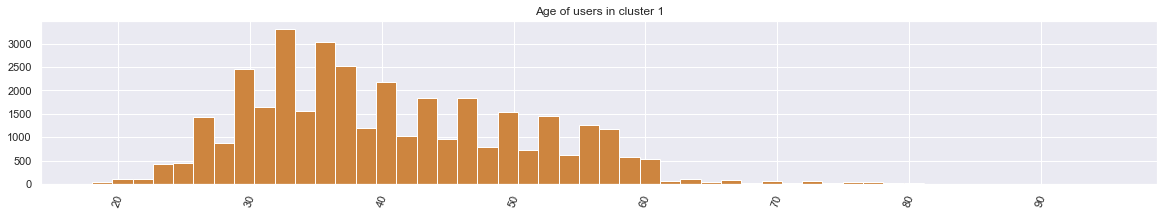

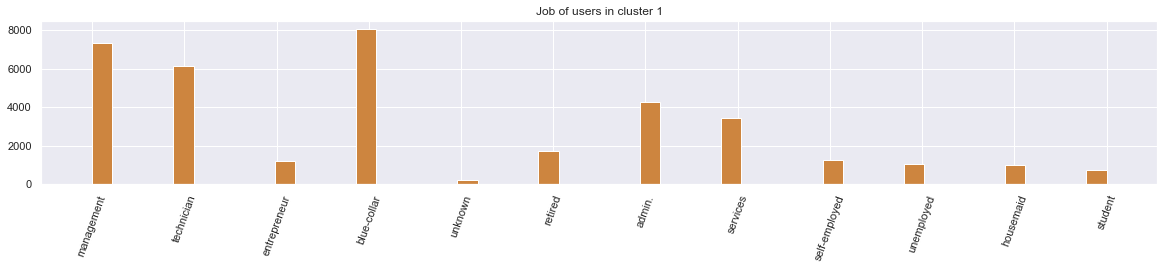

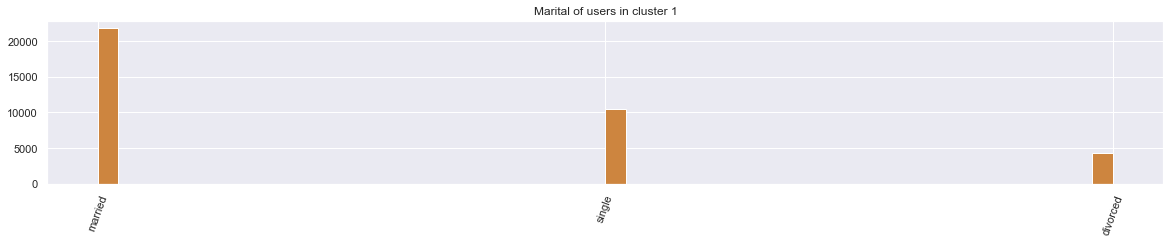

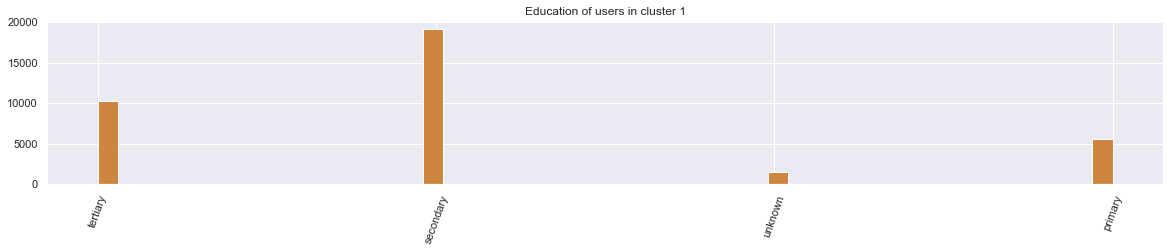

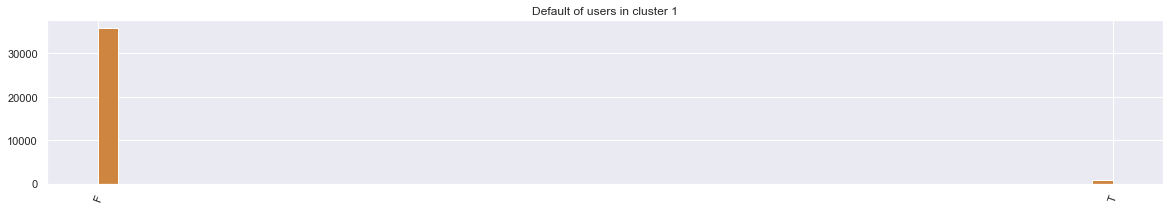

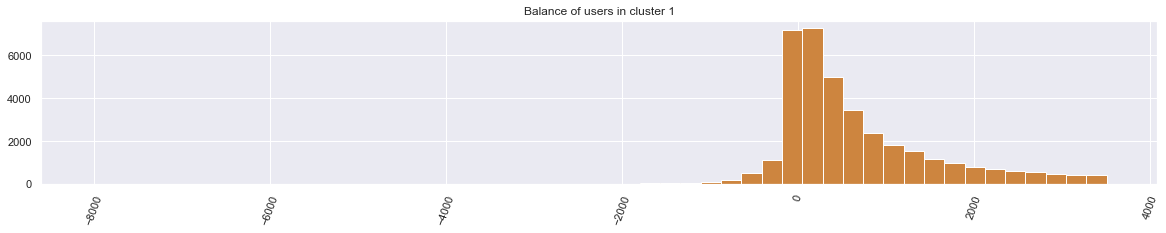

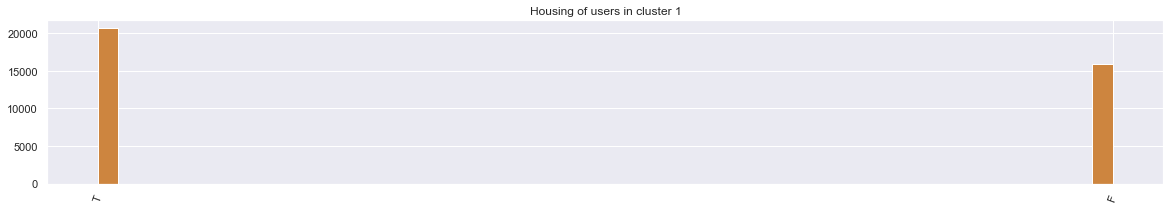

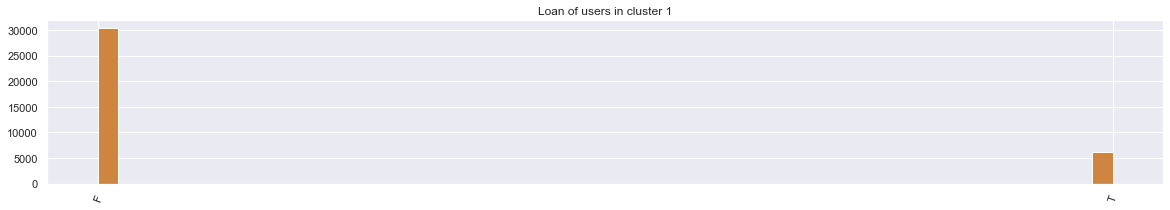

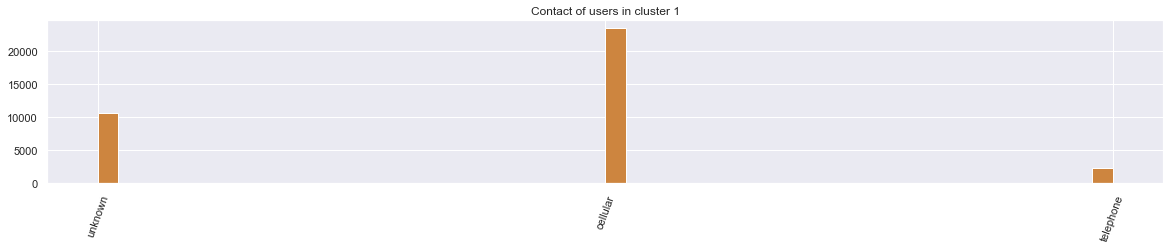

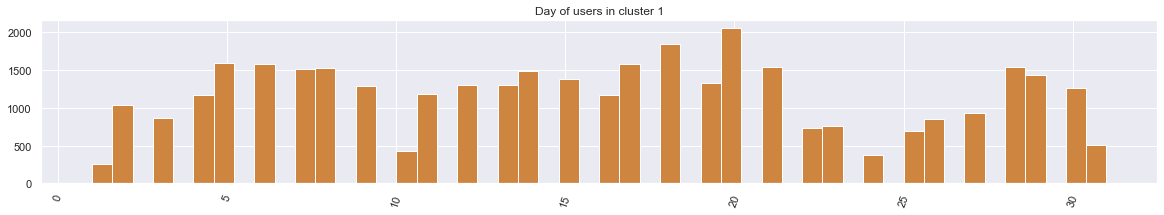

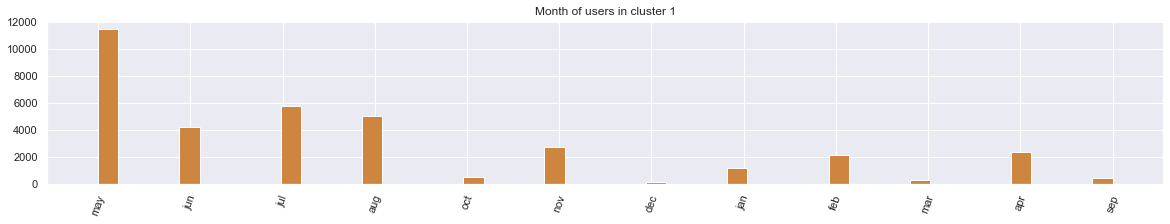

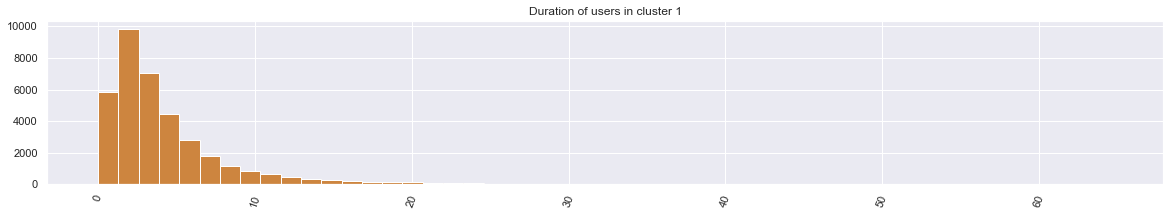

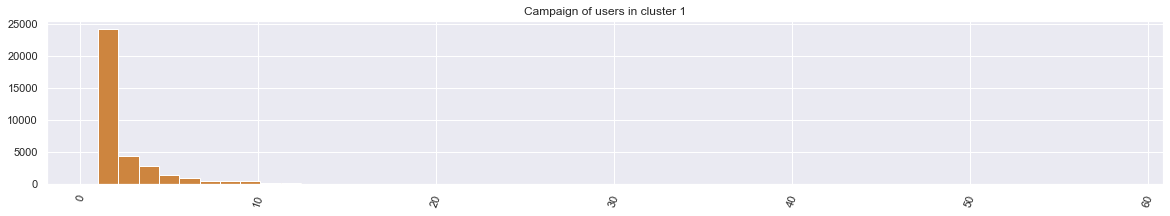

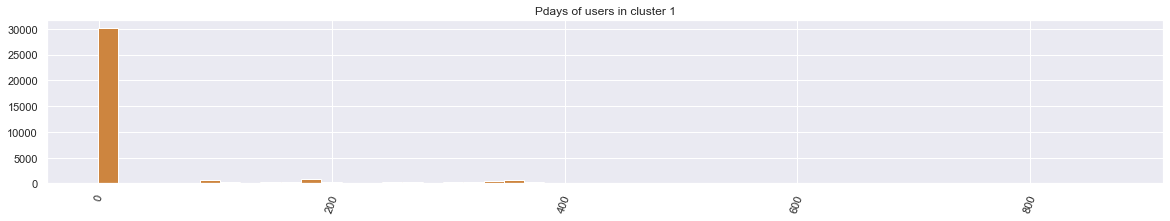

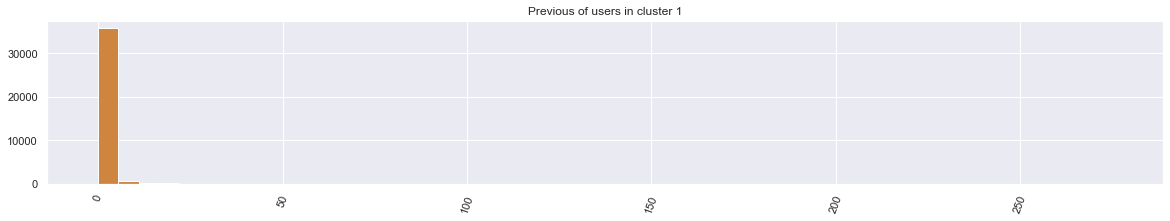

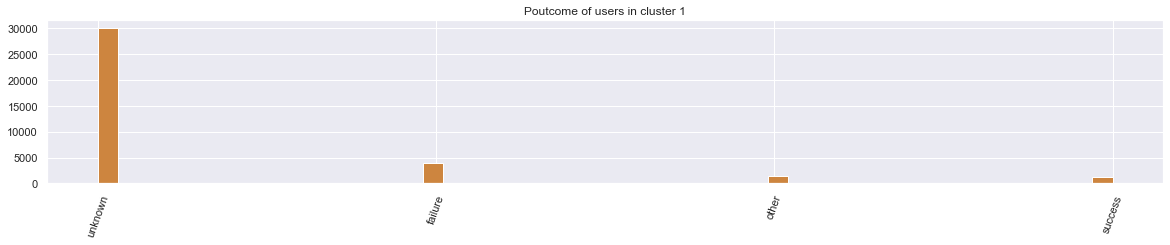

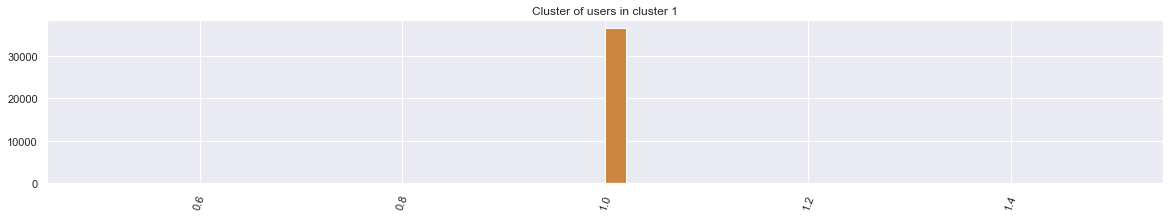

In [10]:
for feature in df.columns:
    plt.subplot(df.loc[:,feature][df['cluster'] == 1].hist(color='peru', figsize=(20,3), bins=50))
    plt.title("%s of users in cluster 1" % feature.title().replace('_', ' '))
    plt.xticks(rotation=70)
    plt.show()    

- No terceiro agrupamento usuários entre **22** e **60** anos são mais frequentes. Cliente com idade inferior aos **30** anos apresentam uma frequencia expressiva, além disso clientes acima de **60** anos se apresentam como uma minória pouco expressiva.


- Os principais clientes desse agrupamento tem como ocupação cargos de **gerencia**, seguidos por **membros da classe trabalhadora** (em geral **trabalhadores de chão de fábrica**) e **técnicos**.Outras ocupações são apresentadas em um segundo escalão de frequência, entre elas estão: **administradores**, **aposentados**, **ocupações relativas a serviços**.



- Novamente, clientes desse agrupamento, em sua maioria são **casados**, seguidos pelo **solteiros** e por fim os **divorciados**.


- Quanto a  **escolaridade** dos clientes nesse agrupamento destacam-se àqueles que possuem **nível superior**, seguidos daqueles com **educação secundária**, que são menos frequentes porém quase igualmente representáveis àqueles que possuem curso superior. e por fim àqueles que possuem apenas a **educação primaria**.


- A presença de de clientes que estão em dias com o cumprimento das obrigações legais ou condições de um empréstimo nesse agrupamento é praticamente unânime.


- Clientes desse agrupamento apresentam a distribuição da sua renda enviesada e com uma longa cauda a direita. Em média com um **saldo anual de 5000 euros**.


- Esse agrupamento é bem dividod quanto a clientes que possem **hipoteca**, apresentando uma diferença mínima entre clientes que possuem e os que não.


- Grande parte dos clientes nesse agrupamento **não possui** empréstimo pessoal e seu principal meio de contato é por meio do telefone **celular**, seguido por um outro meio de contato não conhecido ou não declarado.


- Os dias os quais esses clientes foram contactados pela última vez estão bem pulverizados ao longo do mês, apresentando uma maior intensidade entre os dias **16** e **21**, com destaque para os meses de **Maio**, **Junho**, **Agosto** e **Novembro**. Além disso a duração do ultimo contato com esses clientes não foi superior a **20 minutos**, apresentando uma grande concentração.


- Novamente o número de contatos realizados durante esta campanha e para este agrupamento apresentou um intervalo de frequência expressivo, ficando entre **1*** e **10** contatos possíveis.


- O impacto do resultado das campanhas de marketing anteriores para esses clientes tem uma frequencia maior na categoria **desconhecido ou não relatado**. Uma menor frequência é apresentada denotando **falha**.

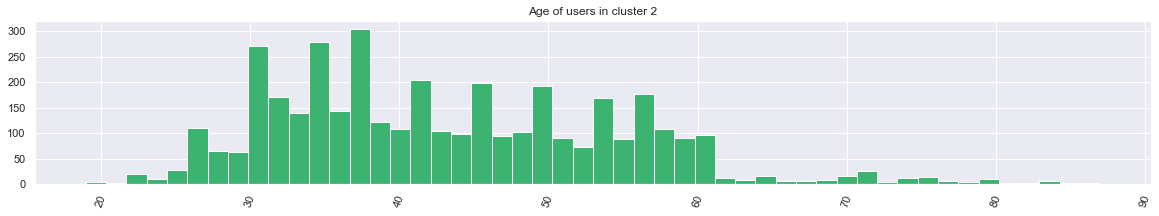

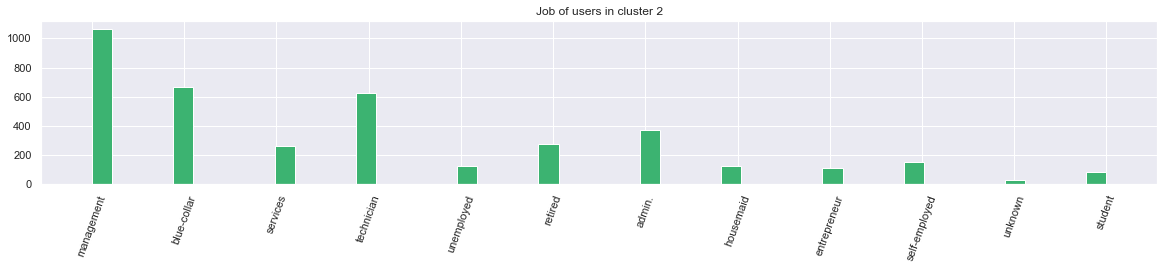

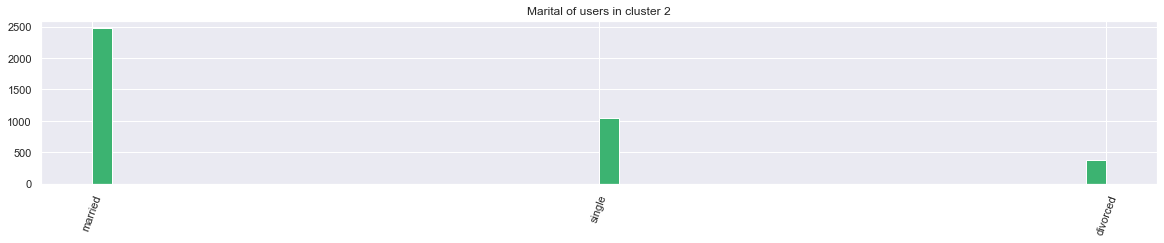

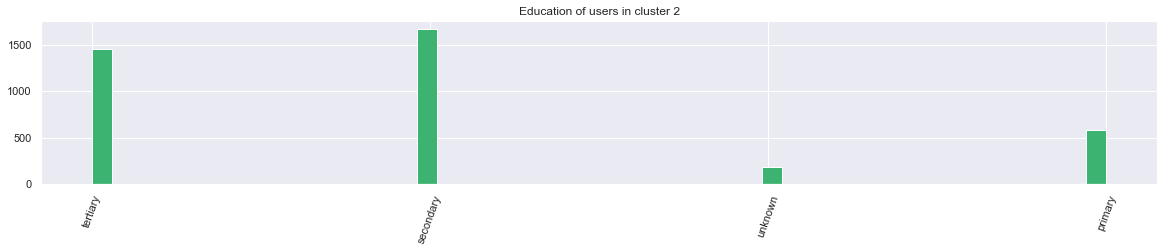

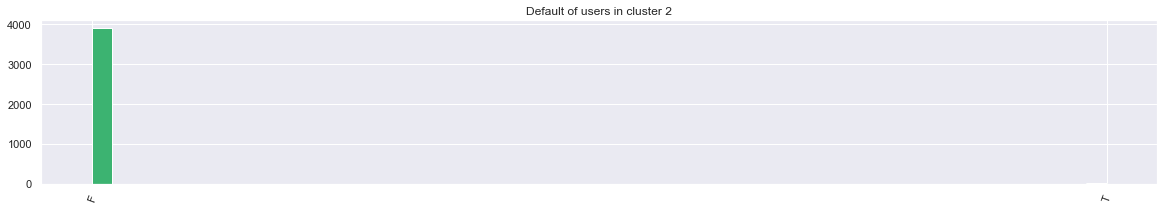

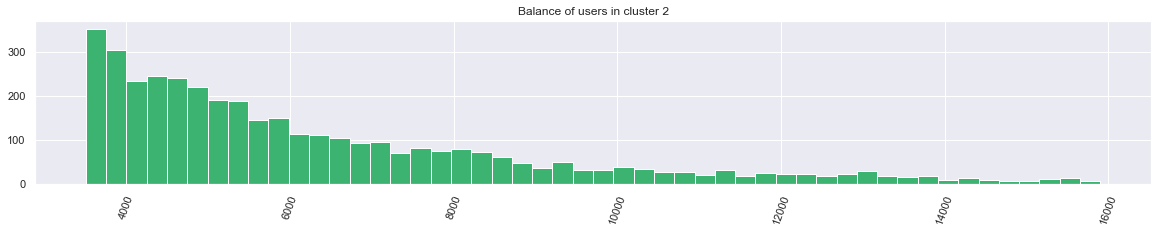

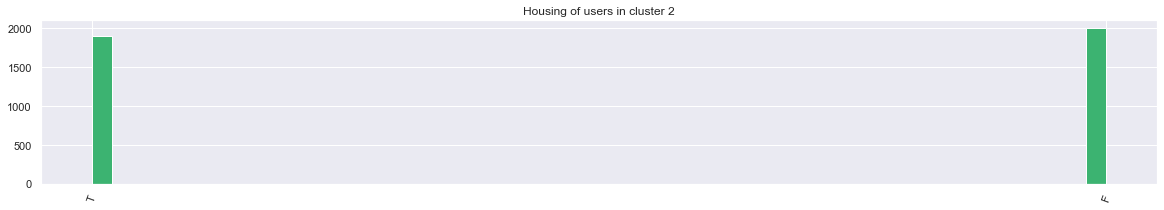

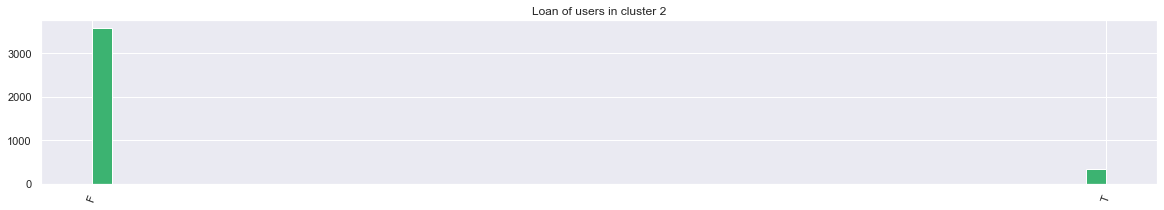

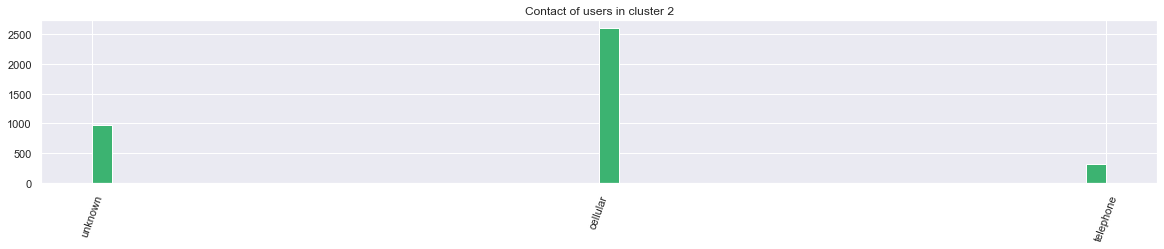

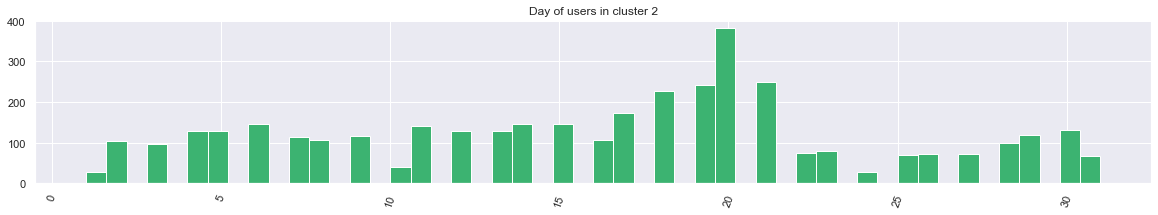

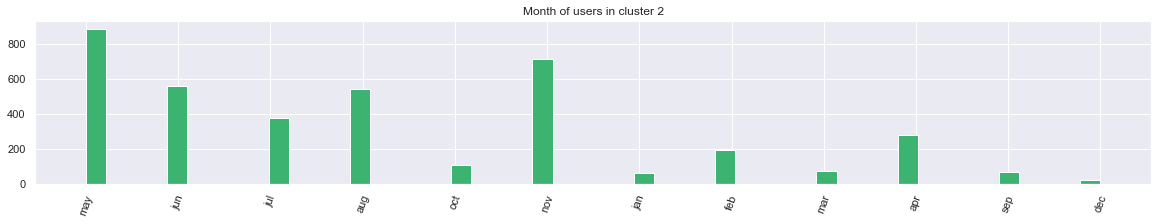

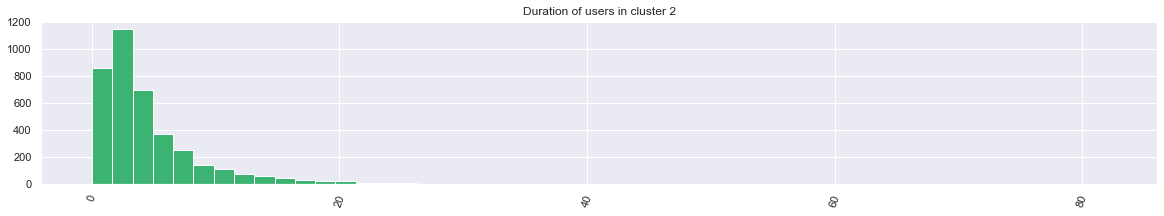

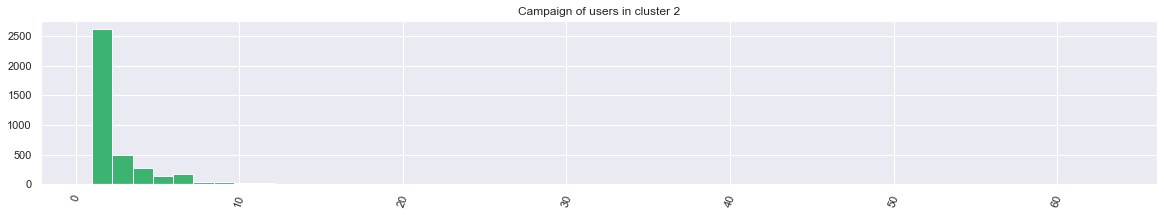

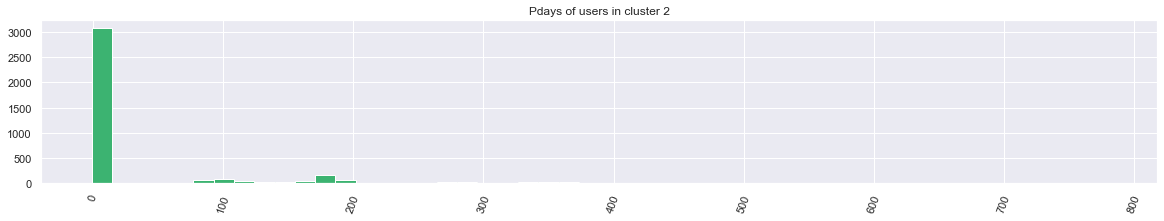

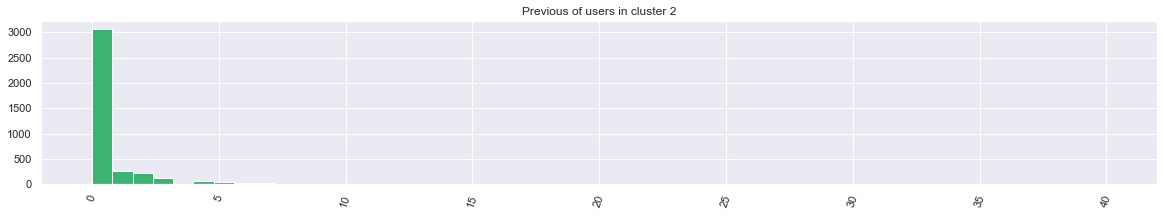

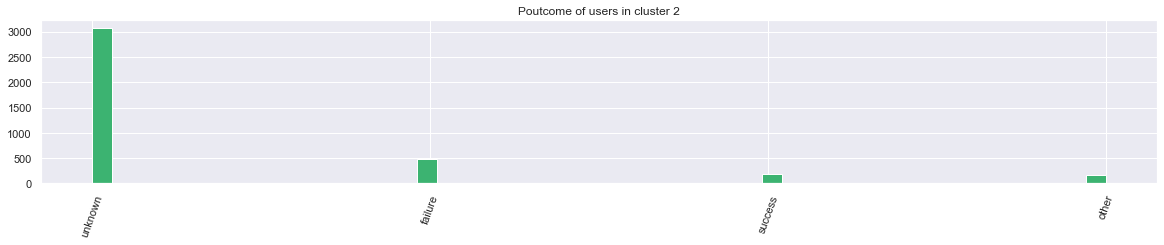

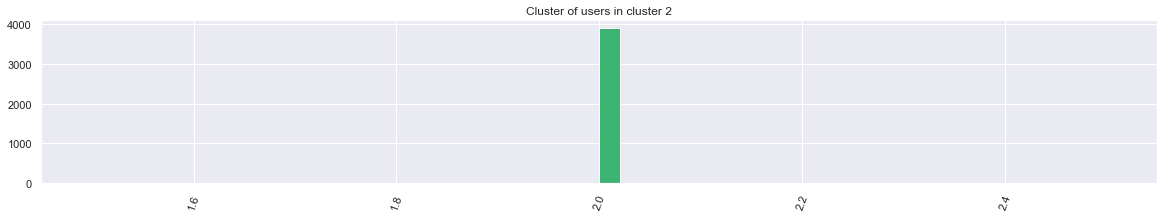

In [11]:
for feature in df.columns:
    plt.subplot(df.loc[:,feature][df['cluster'] == 2].hist(color='mediumseagreen', figsize=(20,3), bins=50))
    plt.title("%s of users in cluster 2" % feature.title().replace('_', ' '))
    plt.xticks(rotation=70)
    plt.show()    

## Avaliação de classificação

Outra análise possível é investigar a conversão de clientes verificando se um determinado cliente se inscreve ou não ao produto. Tecnicamente faremos a comparação de quatro modelos de aprendizado supervisionado definindo um baseline e testá-los no conjunto de dados. Antes disso vamos fazer um pré-processamento nos dados e investigar nossa classe-alvo.

# Pré-processamento de dados

In [12]:
df = data.copy()

Aqui vamos "**binarizar**" nossos dados, dada a facilidade dos algoritmos de machine learning de trabalhar com dados numéricos.

In [13]:
binary = {'no': 0, 'yes': 1}

df['default'] = df['default'].map(binary)
df['housing'] = df['housing'].map(binary)
df['loan']    = df['loan'].map(binary)
df['y']       = df['y'].map(binary)

In [14]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

A seguir vamos aplicar uma estratégia de "**One-hot-encoder**", pelo mesmo motivo citadao anteriormente: algortimos de aprendizado de máquina conseguem trabalhar melhor com dados numéricos.

In [15]:
df = pd.get_dummies(df, prefix=['job'], columns=['job'])
df = pd.get_dummies(df, prefix=['marital'], columns=['marital'])
df = pd.get_dummies(df, prefix=['education'], columns=['education'])
df = pd.get_dummies(df, prefix=['contact'], columns=['contact'])
df = pd.get_dummies(df, prefix=['month'], columns=['month'])
df = pd.get_dummies(df, prefix=['mapoutcomey'], columns=['poutcome'])

In [16]:
df.shape

(40690, 49)

In [17]:
df.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,mapoutcomey_failure,mapoutcomey_other,mapoutcomey_success,mapoutcomey_unknown
0,58,0,2143,1,0,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Vamos investigar agora como estão as distribuições da nossa variável-alvo.

In [18]:
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class: %s, Quantidade: %d, Porcentagem: %.2f%%' % (k, v, per))

Class: 1, Quantidade: 33284, Porcentagem: 81.80%
Class: 0, Quantidade: 7406, Porcentagem: 18.20%


A quantidade das nossas classes confirma a distorção na distribuição de classes, com cerca de **81,80%** dos clientes como não inscritos e cerca de **18.20%** marcadas como incristos

Também podemos dar uma olhada na distribuição das variáveis de entrada criando um histograma para compara-las.

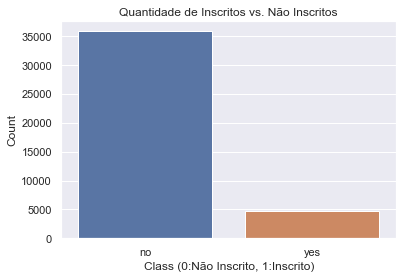

In [19]:
sns.barplot(x=data['y'].value_counts().index, y=data['y'].value_counts())
plt.title('Quantidade de Inscritos vs. Não Inscritos')
plt.ylabel('Count')
plt.xlabel('Class (0:Não Inscrito, 1:Inscrito)');

Um problema com a classificação desequilibrada é que existem poucos exemplos da classe minoritária para um modelo aprender efetivamente o limite da decisão.

Uma maneira de resolver esse problema é exagerar os exemplos na classe minoritária. Isso pode ser conseguido simplesmente duplicando exemplos da classe minoritária no conjunto de dados de treinamento antes da montagem de um modelo. Isso pode equilibrar a distribuição de classe, mas não fornece nenhuma informação adicional ao modelo.


Talvez a abordagem mais amplamente usada para sintetizar novos exemplos seja chamada *Synthetic Minority Oversampling Technique*, ou **SMOTE**, para abreviar. Essa técnica foi descrita por [Nitesh Chawla, et al.](https://www3.nd.edu/~nchawla/) em seu trabalho de 2002.

O SMOTE funciona selecionando exemplos que estão próximos no espaço de recurso, desenhando uma linha entre os exemplos no espaço de recurso e desenhando uma nova amostra em um ponto ao longo dessa linha.

Assim, vamos definir uma instância **SMOTE** com parâmetros padrão que equilibrarão a classe minoritária e, em seguida, caberão e aplicarão em uma etapa para criar uma versão transformada do nosso conjunto de dados.

In [20]:
X = df.drop(['y'], axis=1)
y = df['y']

In [21]:
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X, y)

Uma vez transformados, podemos resumir a distribuição de classe do novo conjunto de dados transformado, que seria esperado agora ser equilibrado com a criação de muitos novos exemplos sintéticos na classe minoritária.

In [22]:
counter = Counter(y_sm)

# scatter plot of examples by class label
for label, _ in counter.items():
    per = v / len(y_sm) * 100
    print('Class: %s, Quantidade: %d, Porcentagem: %.3f%%' % (k, v, per))

Class: 0, Quantidade: 7406, Porcentagem: 10.314%
Class: 0, Quantidade: 7406, Porcentagem: 10.314%


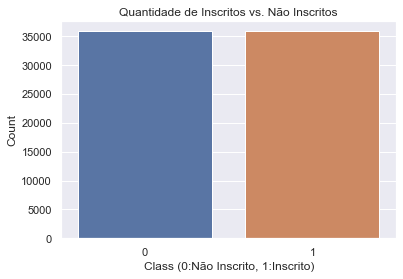

In [23]:
sns.barplot(x=y_sm.value_counts().index, y=y_sm.value_counts())
plt.title('Quantidade de Inscritos vs. Não Inscritos')
plt.ylabel('Count')
plt.xlabel('Class (0:Não Inscrito, 1:Inscrito)');

## Comparação de Modelos

### Divisão dos dados

Agora todas as variáveis categóricas foram convertidas em recursos numéricos e todos os recursos numéricos foram normalizados. Como sempre, agora vamos dividir os dados (recursos e seus rótulos) em conjuntos de treinamento e teste, tomando o cuidado de passar nossos dados balanceados. **67%** dos dados serão usados para treinamento e **33%** para testes.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.33, random_state=0)

print("Conjunto de treino possui {} amostras.".format(X_train.shape[0]))
print("Conjunto de treino possui  {} amostras.".format(X_test.shape[0]))

Conjunto de treino possui 48110 amostras.
Conjunto de treino possui  23696 amostras.


Para identificar o melhor modelo para a classificação dos nosso clientes vamos comparar alguns modelos de forma a encontrar o àquele que melhor resolve nosso problema. Inicialmente definiremos um baseline e para isso usaremos uma biblioteca de automl.

A intuição aqui é a seguinte: Vamo colocar uma biblioteca automatica para encontrar o nosso baseline e tentaremos bater esse baseline de forma artesanal, tunando hiperparâmentros do modelo, assim temos uma maior chance de chegar em um minimo local muito mais rapido do que de forma empirica.

In [43]:
tpot = TPOTClassifier(generations=5,
                      scoring = ('f1_weighted','accuracy'),
                      population_size=50, 
                      verbosity=2, 
                      random_state=42, 
                      n_jobs=-1)

In [44]:
tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.9462481812512991
Generation 2 - Current best internal CV score: 0.9473913947204323
Generation 3 - Current best internal CV score: 0.9473913947204323
Generation 4 - Current best internal CV score: 0.9473913947204323
Generation 5 - Current best internal CV score: 0.9473913947204323
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=9, max_features=0.25, min_samples_leaf=19, min_samples_split=14, n_estimators=100, subsample=0.9000000000000001)


TPOTClassifier(generations=5,
               log_file=<ipykernel.iostream.OutStream object at 0x106aeca90>,
               n_jobs=-1, population_size=50, random_state=42,
               scoring=('f1_weighted', 'accuracy'), verbosity=2)

Para a construção do nosso baseline, demos preferência ao **F1-score**, que é uma média harmônica ponderada e alcançamos uma precisão de **94.73%**. Nossa biblioteca informa também que o classificador utilizado para alcançar o melhor desempenho foi o **GradientBoostingClassifier**, além dos hiperparâmetros utilizados. 

Agora que criamos nosso baseline utilizando uma estratégia de **Auto ML**, vamos tentar superar esse baseline através de outros modelos que, entre outras coisas, nos permitem uma configuração mais apurada de hiperparâmentros de forma que possamos aumentar a precisão do classificador.

## Criando um pipeline de treinamento e previsão

Para avaliar adequadamente o desempenho de cada modelo que escolhemos, é importante que você crie um pipeline de treinamento e previsão que permita treinar modelos rápida e eficazmente usando vários tamanhos de dados de treinamento e executar previsões nos dados de teste.

In [45]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() 
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() 
    
    results['train_time'] = end - start
        
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    results['f1_train'] = f1_score(y_train[:300],predictions_train,0.5)
        
    results['f1_test'] = f1_score(y_test,predictions_test,0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

In [46]:
rf_model = RandomForestClassifier(
    random_state=200, 
    class_weight='balanced', 
    n_estimators=1000, 
    min_samples_leaf=8)

lgbm_model = LGBMClassifier(
    random_state=200, 
    class_weight='balanced', 
    n_estimators=100,     
    learning_rate=0.009, 
    num_leaves=2**3)

adab_model = AdaBoostClassifier(
    n_estimators=100, 
    random_state=0)

samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

results = {}
for clf in [rf_model, lgbm_model, adab_model]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

RandomForestClassifier trained on 481 samples.
RandomForestClassifier trained on 4811 samples.
RandomForestClassifier trained on 48110 samples.
LGBMClassifier trained on 481 samples.
LGBMClassifier trained on 4811 samples.
LGBMClassifier trained on 48110 samples.
AdaBoostClassifier trained on 481 samples.
AdaBoostClassifier trained on 4811 samples.
AdaBoostClassifier trained on 48110 samples.


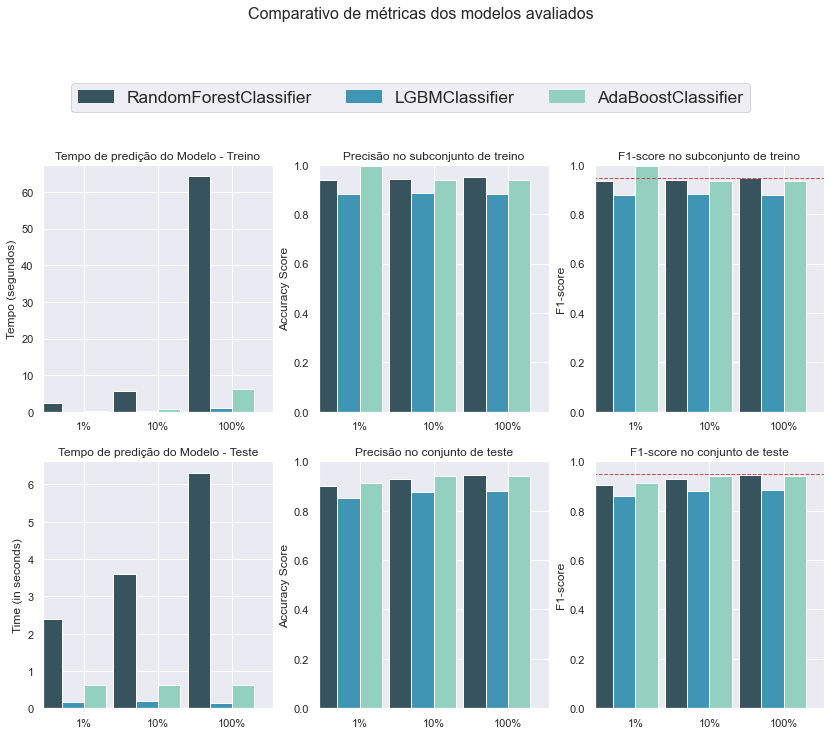

In [47]:
baseline_f1_score = 0.9473

evaluate(results, accuracy_score, baseline_f1_score)

In [48]:
for i in results.items():
    print("--- "+ i[0] +" ---")
    print(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))
    print(" ")

--- RandomForestClassifier ---
                  1%       10%       100%
train_time  2.422316  5.718236  64.220991
pred_time   2.396871  3.606059   6.304230
acc_train   0.940000  0.943333   0.950000
acc_test    0.901587  0.928764   0.943788
f1_train    0.934783  0.938182   0.944649
f1_test     0.904049  0.929224   0.943492
 
--- LGBMClassifier ---
                  1%       10%      100%
train_time  0.061622  0.162342  1.040556
pred_time   0.160642  0.195343  0.152998
acc_train   0.880000  0.886667  0.883333
acc_test    0.850228  0.874114  0.878207
f1_train    0.875862  0.880282  0.877193
f1_test     0.858577  0.879655  0.882597
 
--- AdaBoostClassifier ---
                  1%       10%      100%
train_time  0.308728  0.751447  6.230920
pred_time   0.612002  0.620315  0.618443
acc_train   0.996667  0.940000  0.940000
acc_test    0.911251  0.938386  0.940581
f1_train    0.996390  0.933333  0.932331
f1_test     0.912495  0.938397  0.939962
 


Observando os resultados acima, dos três modelos, o AdaBoost é o mais apropriado para a nossa tarefa.

Em primeiro lugar, é o classificador que apresenta o melhor desempenho nos dados de teste, tanto em termos de precisão quanto de pontuação. Também leva um tempo razoavelmente baixo para treinar no conjunto de dados completo,  Portanto, ele deve escalar bem, mesmo se tivermos mais dados.

Por padrão, o **Adaboost** usa uma única árvore de decisão de profundidade 1 como seu classificador base, que pode manipular dados categóricos e numéricos. Classificadores fracos são relativamente mais rápidos para treinar, portanto, o tamanho do conjunto de dados não é um problema para o algoritmo. 

Veremos como se comportam as matrizes de confusão desses classificadores.

In [49]:
for i,model in enumerate([rf_model,lgbm_model,adab_model]):
    print("--- "+ model.__class__.__name__ +" ---")
    print(classification_report(y_test, model.predict(X_test)))

--- RandomForestClassifier ---
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     11750
           1       0.96      0.93      0.94     11946

    accuracy                           0.94     23696
   macro avg       0.94      0.94      0.94     23696
weighted avg       0.94      0.94      0.94     23696

--- LGBMClassifier ---
              precision    recall  f1-score   support

           0       0.90      0.85      0.87     11750
           1       0.86      0.91      0.88     11946

    accuracy                           0.88     23696
   macro avg       0.88      0.88      0.88     23696
weighted avg       0.88      0.88      0.88     23696

--- AdaBoostClassifier ---
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11750
           1       0.96      0.92      0.94     11946

    accuracy                           0.94     23696
   macro avg       0.94      0.94      0.94    

Observando os resultados acima, dos três modelos, o **AdaBoost** é o mais apropriado para a nossa tarefa.

Em primeiro lugar, é o classificador que apresenta o melhor desempenho nos dados de teste, tanto em termos de precisão quanto na média harmonica. Também leva um tempo razoavelmente baixo para treinar no conjunto de dados completo. Portanto, ele deve escalar bem, mesmo se tivermos mais dados.

# Iterpretabilidade do Modelo

Uma tarefa importante ao realizar o aprendizado supervisionado em um conjunto de dados como os dados do censo que estudamos aqui é determinar quais recursos fornecem o poder mais preditivo. Ao focarmos no relacionamento entre  algumas características cruciais, simplificamos nossa compreensão do fenômeno, que é sempre uma coisa útil a se fazer. No caso deste projeto, isso significa que desejamos identificar um pequeno número de recursos que definem mais claramente quando um cliente se inscreve em um produto ou não.

Sabemos que existem dezesseis recursos disponíveis para cada cliente registrado nos nossos dados. Agora vamos ver como nosso algoritmo classifica os recursos de acordo. a sua importância.

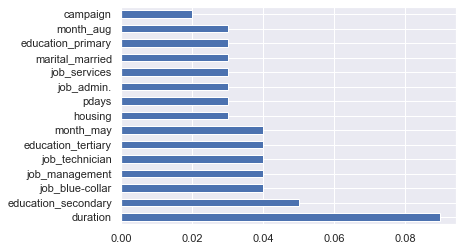

In [50]:
feat_importances = pd.Series(adab_model.feature_importances_, index= X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.savefig("../images/adab-feat-import.png", bbox_inches='tight')
plt.show()

Para classificar os agrupamentos utilizamos o **Adaboost** enfatiza alguns recursos mais importantes. É possivel observar acima que uma das caracteristicas mais importantes para o modelo é a duração do ultimo contato com o cliente, seguidas pela escolaridade (**educação secundária**) e a ocupação no caso de clientes que pertençam a ocupação **classe trabalhadora**.

## Melhorias

- Compilar mais características de cada cliente como **quantidade de acessos**, **descrição dos produtos**, **numeros de visita** em cada produto, **intencionais compradores**, etc.


- Compilar mais características de cada cliente como **renda**, **endereço**, **padrões de consumo**, etc.


-  A utilização de algum processo de otimização dos modelos como **Inferência Bayesiana**.